In [1]:
#Importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
#Data Loading
df = pd.read_csv("data/Indian Unicorn startups 2023 updated.csv")
df.head()

,No.,Company,Sector,Entry Valuation^^ ($B),Valuation ($B),Entry,Location,Select Investors
0,1,InMobi,Adtech - Mobile Ads,1.0,1.0,Sep/2011,Bangalore/Singapore,"KPCB, Sherpalo Ventures, SoftBank"
1,2,Flipkart^,E-Commerce,1.0,37.6,Feb/2012,Bangalore/Singapore,"Accel, Tiger Global, Naspers, SoftBank, Tencent"
2,3,Mu Sigma,SaaS - Analytics,1.0,1.5,Feb/2013,Bangalore/Chicago,"Accel, Sequoia Capital, General Atlantic"
3,4,Snapdeal*,E-Commerce,1.8,2.4,Oct/2014,Delhi,"Kalaari Capital, Nexus Ventures, Bessemer, Sof..."
4,5,PayTM^,Fintech - Payments & Wallet,1.7,16.0,Feb/2015,Noida,"Saama Capital, Elevation Capital, Alibaba, Ber..."


In [3]:
#Drop Irrelevant columns
df = df.drop(columns = ['No.', 'Company'])
#Rename columns
df = df.rename(columns = {'Entry Valuation^^ ($B)' : 'Entry_Valuation', 'Valuation ($B)' : 'Valuation'})

In [4]:
#Extract exact year
df['Entry_year'] = pd.to_datetime(df['Entry'], format = '%b/%Y').dt.year
df = df.drop(columns = ['Entry'])
#Investor Count feature
df['Investor_Count'] = df['Select Investors'].apply(lambda x: len(str(x).split(',')))
df = df.drop(columns = ['Select Investors'])

In [5]:
#Features and target
X = df.drop(columns = ['Valuation'])
y = df['Valuation']

numerical_features = ['Entry_Valuation', 'Entry_year', 'Investor_Count']
categorical_features = ['Sector', 'Location']

In [6]:
numeric_transformer = Pipeline(steps = [('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(drop = 'first', handle_unknown = 'ignore')
preprocessor = ColumnTransformer(transformers = [('num', numeric_transformer, numerical_features), ('cat', categorical_transformer, categorical_features)])

In [7]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [8]:
#function for visualizing actual vs predicted
def plot_actual_vs_pred(y_test, y_pred, model_name):
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()])
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted - {model_name}")
    plt.show()

In [9]:
#Evaluation function for all models
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    plot_actual_vs_pred(y_test, y_test_pred, name)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2 = r2_score(y_test, y_test_pred)

    return{'Model' : name, 'Train RMSE' : train_rmse, 'Test RMSE' : test_rmse, 'R2 Score' : r2}

In [10]:
models = []

#Linear regression
models.append((
    "Linear Regression", 
    Pipeline(steps = [
        ('preprocessor', preprocessor), 
        ('model', LinearRegression())
    ])
))

#Ridge Regression
models.append((
    "Ridge Regression",
    Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('model', Ridge(alpha = 1.0))
    ])
))

#Lasso Regression
models.append((
    "Lasso Regression",
    Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('model', Lasso(alpha = 0.01))
    ])
))

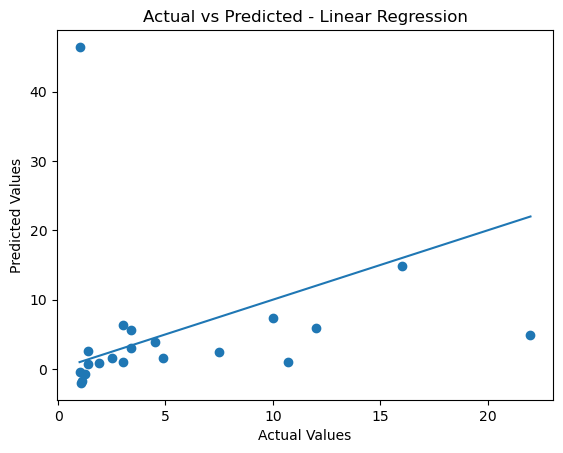

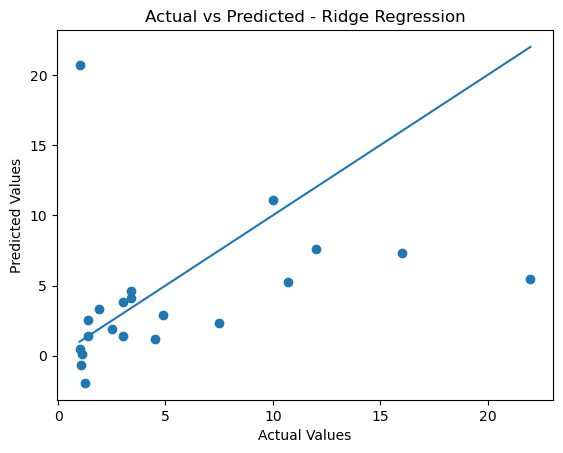

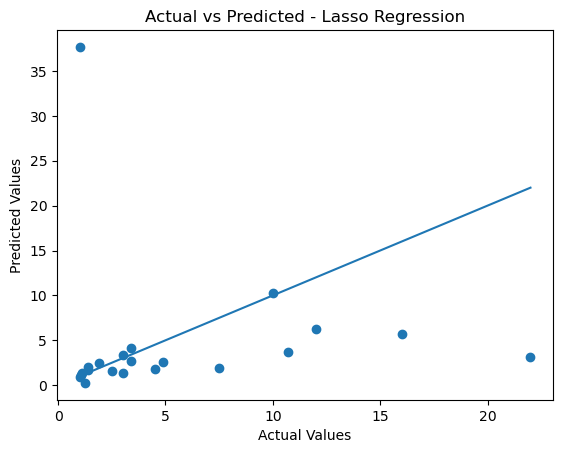

,Model,Train RMSE,Test RMSE,R2 Score
0,Linear Regression,0.322114,11.084344,-2.958933
1,Ridge Regression,2.262002,6.371647,-0.308162
2,Lasso Regression,0.814703,9.611607,-1.976803


In [11]:
#run evaluation for all models
results = []
for name, model in models:
    results.append(
        evaluate_model(name, model, X_train, X_test, y_train, y_test)
    )

results_df = pd.DataFrame(results)
results_df

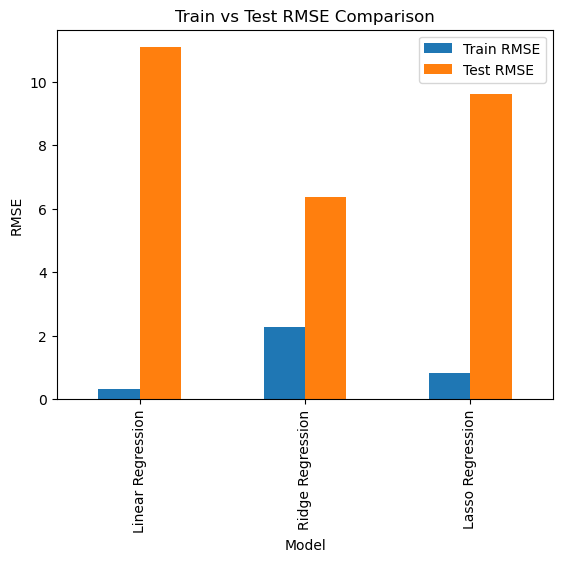

In [12]:
#Visual Comparison
results_df.set_index('Model')[['Train RMSE', 'Test RMSE']].plot(kind = 'bar')
plt.ylabel("RMSE")
plt.title("Train vs Test RMSE Comparison")
plt.show()

In [13]:
best_model = results_df.sort_values(by = 'Test RMSE').iloc[0]
print("Best Model:", best_model)

Best Model: Model         Ridge Regression
Train RMSE            2.262002
Test RMSE             6.371647
R2 Score             -0.308162
Name: 1, dtype: object


In [14]:
def get_user_input():
    data = {}
    for col in X.columns:
        value = input(f"Enter value for {col}: ")
        data[col] = [value]
    return pd.DataFrame(data)    
user_input = get_user_input()
for name, model in models:
    prediction = model.predict(user_input)[0]
    print(f"{name} Prediction: {prediction:.2f}")


Enter value for Sector:  FinTech
Enter value for Entry_Valuation:  1
Enter value for Location:  Bengaluru
Enter value for Entry_year:  2018
Enter value for Investor_Count:  5


Linear Regression Prediction: 5.83
Ridge Regression Prediction: 4.68
Lasso Regression Prediction: 3.05
